# Squeezed Lasing: symmetry-broken states ($\varphi$ variation)

In [454]:
import math as math
import numpy as np
import scipy as scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import sys
import os

from qutip import *
from src_2_0 import *

In [455]:
def H_def(a_s,sigma,delta_s,delta_sigma,g_0,r,theta,omega,phi): # Defines the Hamiltonian of the system. It considers a coupling between a photonic cavity and a one-atom subsystem.
    return delta_s*a_s*a_s.dag()+delta_sigma*sigma.dag()*sigma+g_0*np.cosh(r)*(a_s.dag()*sigma+a_s*sigma.dag())+omega*(a_s*np.exp(-1j*phi)+a_s.dag()*np.exp(1j*phi))

In [456]:
def Lops_def(a_s,sigma,k,P,eta): # Defines the system's collapse (Lindblad) operators, one that represents incoherent pumping and other that describes photon loss.
    return [np.sqrt(P)*sigma.dag(),np.sqrt(k*(1+eta))*a_s]

#### Parameters

In [457]:
### General parameters ###

N = 300 # Dimension of the Hilbert space of the cavity (poner 500)
n_q = 100 # Photon saturation number
g_0 = 0.01 # Light-matter coupling
C = 1 # Cooperativity (equal to the pumping parameter p)
eta = 0 # Photon loss due to other decay channels
delta_c = 0.1 # Detuning w_c-w_p

### Squeezed parameters ###

r = 0.5 # Squeezing parameter
theta = np.pi # Squeezing angle

### Symmetry broken parameters ###

omega = 0.45 # Amplitude of the coherent driving with well defined phase
phi = np.linspace(0,2*np.pi,25) # Fixed phase

#### Parameter-dependent quantities

In [458]:
k = g_0*np.sqrt(2/(C*n_q)) # Photon decay rate
P = 2*n_q*k # Incoherent pumping
alpha = (np.e**(4*r)-1)/(np.e**(4*r)+1) # omega_p/delta_c
omega_p = alpha*delta_c # Amplitude of the coherent drive (down-conversion)
delta_s = delta_c*np.sqrt(1-(omega_p/delta_c)**2) # Detuning in the squeezed basis
delta_sigma = delta_s # Detuning w_sigma-w_p (the same as delta_s to apply RWA)
C_s = C*np.cosh(r)**2 # Squeezed cooperativity (equal to the squeezed pumping parameter p_s)

Check RWA conditions

In [459]:
print(delta_c,delta_s,delta_sigma,g_0*np.sinh(r))

0.1 0.06480542736638853 0.06480542736638853 0.005210953054937474


In [460]:
aux = 1

if delta_sigma > aux*g_0*np.sinh(r):
    if delta_s > aux*g_0*np.sinh(r):
        print('double check')
    else:
        print('Check values of delta_c')
else:
    print('Check value of r')

double check


#### Operators

In [461]:
a_s = tensor(destroy(N),identity(2)) # Annihilation operator of the squeezed basis
a = a_s*np.cosh(r)-np.exp(-1j*theta)*a_s.dag()*np.sinh(r) # Annihilation operator of the bare basis
sigma = tensor(identity(N),basis(2,0)*basis(2,1).dag()) # Lowering operator of the two-level system
S = (0.5*(r*np.exp(-1j*theta)*a_s*a_s-np.conj(r*np.exp(-1j*theta))*a_s.dag()*a_s.dag())).expm() # Squeezing operator

#### Steady-states

In [462]:
rho_ss = [] # Steady states of the system in the squeezed basis
rho_ss_bare = [] # Steady states of the system in the bare basis

for i in tqdm(range(np.size(phi))):
     rho_ss.append(steadystate(H_def(a_s,sigma,delta_s,delta_sigma,g_0,r,theta,omega,phi[i]),Lops_def(a_s,sigma,k,P,eta))) # Calculate the density matrix of the steady states in the squeezed basis
     rho_ss_bare.append(S*rho_ss[i]*S.dag()) # Calculate the density matrix of the steady states in the bare basis

100%|██████████| 25/25 [58:10<00:00, 139.63s/it]


### 1. Photon distribution

In [463]:
n_dist = [] # Photon number distribution
n_s = np.zeros(np.size(phi),dtype=complex) # Photon population in the squeezed basis

for i in tqdm(range(np.size(phi))):
    n_dist.append(rho_ss_bare[i].ptrace(0).diag())  # Save the diagonal terms of the density matrix
    n_s[i]= expect(a_s.dag()*a_s,rho_ss[i]) # Calculate the photon population in the squeezed basis

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 38.69it/s]


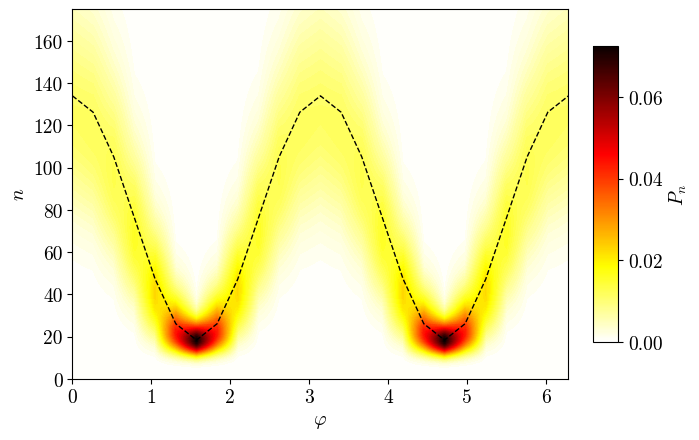

In [464]:
fig,ax = plt.subplots()

nrm = mpl.colors.Normalize(0,np.abs(np.array((n_dist)).max())) # Colorbar settings
cbar = fig.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.hot_r),cax = ax.inset_axes([1.05, 0.1, 0.05, 0.8]))
cbar.set_label('$P_n$',fontsize=14)

ax.contourf(phi,np.linspace(0,N-1,N),np.transpose(np.array((n_dist))), 100, cmap=cm.hot_r, norm=nrm) # Plot of the distribution
ax.plot(phi,n_s*(np.cosh(2*r)-np.sinh(2*r)*np.cos(2*phi+theta))+np.sinh(r)**2,'--',lw=1,color='k')

plt.xlim([np.min(phi),np.max(phi)]) # Figure settings
plt.ylim([0,175])
# plt.title('Photon number distribution',fontsize=14)
plt.xlabel(r'$\varphi$',fontsize=14)
plt.ylabel('$n$',fontsize=14)
plt.show()

In [476]:

esp = np.column_stack([phi,n_dist,n_s])
np.savetxt('.\SEC_V_B/PHI_VAR_'+str(format(omega,'.1f'))+'_'+str(format(C,'.1f'))+'_'+str(format(r,'.2f'))+'.txt',esp)


### 2. Wigner distribution

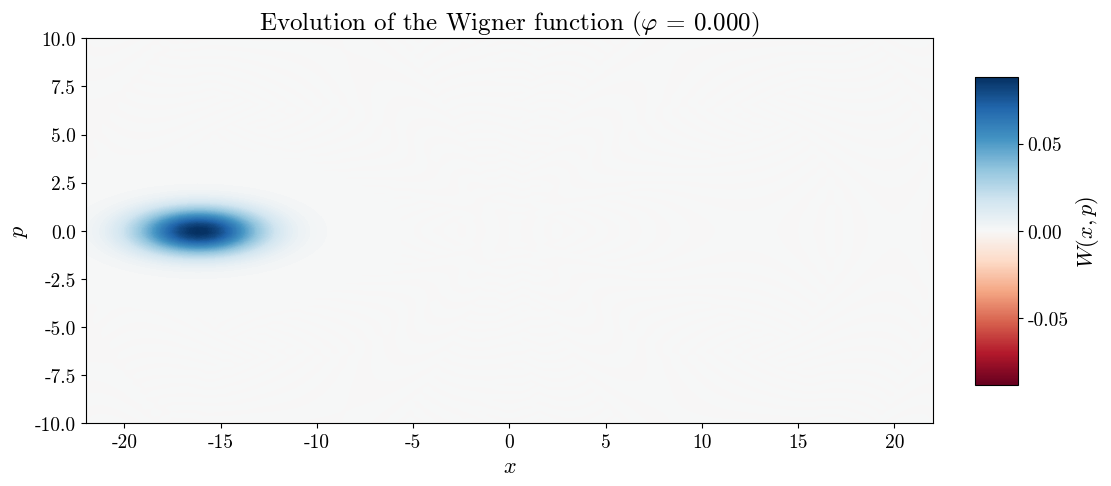

In [479]:
wigner_rep(rhos = rho_ss_bare).wigner_animation(22,10,phi,figname = 'Var_PHI',speed = 100, mrname = r'$\varphi$') # Create an animation for the whole range of phi

### 3. Quadrature fluctuations

In [467]:
quad_ang = np.pi-(theta)/2 # Quadrature angle that specifies the field's quadrature to measure
X_ang = a*np.exp(-1j*quad_ang)+a.dag()*np.exp(1j*quad_ang) # Chosen quadrature operator

In [468]:
fluc = np.zeros(np.size(phi), dtype = complex)

for i in range(np.size(phi)):
    fluc[i] = np.sqrt(expect(X_ang**2,rho_ss_bare[i])-expect(X_ang,rho_ss_bare[i])**2)

In [469]:
psi = tensor(squeeze(N,r*np.exp(-1j*(np.pi)))*displace(N,np.sqrt(n_s[1])*np.exp(1j*(phi[1])))*basis(N),basis(2,0))

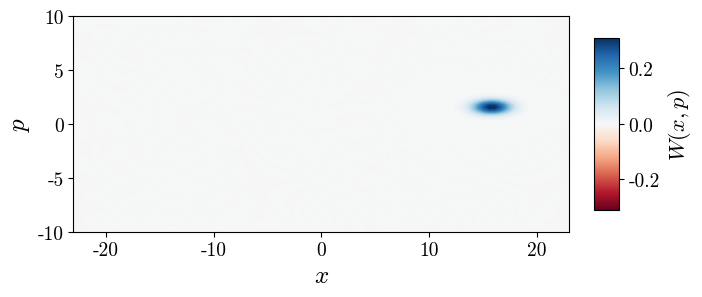

In [471]:
wigner_rep(rhos = psi*psi.dag()).wigner_plot(23,10)

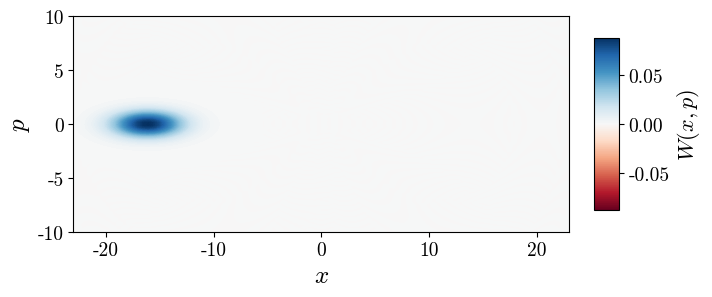

In [477]:
wigner_rep(rhos = rho_ss_bare[0]).wigner_plot(23,10)

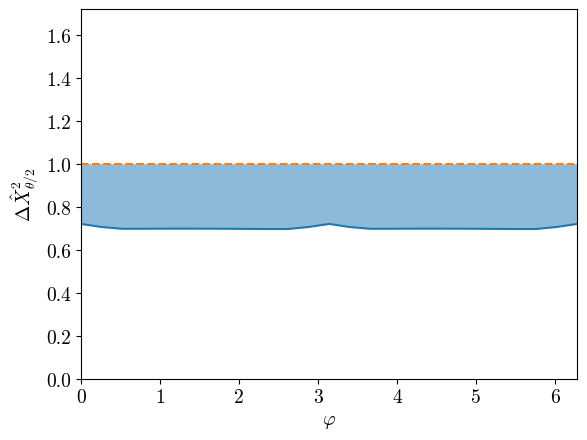

In [478]:
plt.plot(phi,fluc)
plt.plot([np.min(phi),np.max(phi)],[1,1],'--')
plt.fill_between(phi,1,fluc,alpha=0.5,where=np.array(fluc)<1.1)
plt.xlim([np.min(phi),np.max(phi)])
plt.ylim([0,np.max(fluc)+1])
# plt.title('Quadrature fluctuations',fontsize=14)
plt.xlabel(r'$\varphi$',fontsize=14)
plt.ylabel(r'$\Delta\hat{X}_{\theta/2}^2$', fontsize=14)
plt.show()